In [29]:
%%writefile pa.cpp

#include <stdio.h>
#include <stdlib.h>
#include <unistd.h>
#include <math.h>

double *matrix;
double *vector;
double *phi_prev;
double *phi;

const int PHI_COUNT = 5;  // Количество узлов
const int SM = 10;        // Количество позиций на производные
                          // и интегралы по узловым потенциалам
const int dimension = 17; // Итоговая размерность системы

const double scheme_E2 = 5;
const double scheme_C2 = 0.1e-6;
const double scheme_L = 0.1;
const double scheme_R1 = 1000.0;
const double scheme_R4 = 10000.0;

const double diode_I_t = 1e-12;
const double diode_C_b = 2e-12;
const double diode_R_b = 20.0;
const double diode_MFT = 0.026;
const double diode_R_d = 1000000.;

int Gauss(){ // Метод Гаусса
    long int i, j, k;
    int N = dimension;
    double diagonalElement;
    for (k = 0; k < N; k++){
        diagonalElement = matrix[N * k + k];
        if (diagonalElement == 0)
            return 1;
        for (j = k; j < N; j++)
            matrix[N * k + j] /= diagonalElement;
        vector[k] /= diagonalElement;
        for (i = k + 1; i < N; i++){
            diagonalElement = matrix[N * i + k];
            for (j = k; j < N; j++)
                matrix[N * i + j] -= matrix[N * k + j]*diagonalElement;
            vector[i] -= vector[k] * diagonalElement;
        }
    }
    for (i = N - 2; i >= 0; i--) // Обратный ход Гаусса
        for (j = i + 1; j < N; j++)
            vector[i] -= matrix[N * i + j] * vector[j];
    return 0;
}

double VoltageSource(double t){ // Синусоидальный источника тока
    double amplitude = 10.0;
    double frequency = 2 * M_PI / 0.0001;
    double phase = 0.0;
    return amplitude * sin(frequency * t + phase);
}

double MaxElement(double *vector, int N){ // Нахождение макс элемента 
                                          // (для определения макс изменения фазовых переменных)
    int i;
    double result = 0;
    for (i = 0; i < N; i++)
        if (result < fabs(vector[i])) 
            result = fabs(vector[i]);
    return result;
}

void Reset(){ // Функция обнуления матриц коффициентов А и vector
    for (int i = 0; i < dimension; i++){ 
        for (int j = 0; j < dimension; j++){
            matrix[dimension * i + j] = 0;
        }
        vector[i] = 0;
    }
}

void SA_Init(double dt) // Инициализация первых SM строк матрицы 
                        // (На производные и интегралы по узловым потенциалам)
{
    for (int i = 0; i < PHI_COUNT; i++)
    {
        matrix[dimension*i + i] += 1;
        matrix[dimension*i + 2*PHI_COUNT+i] -= 1/dt;
        vector[i] += phi[i] - (phi[2*PHI_COUNT+i] - phi_prev[2*PHI_COUNT+i])/dt;
        
        matrix[dimension*(PHI_COUNT+i) + PHI_COUNT+i] += 1;
        matrix[dimension*(PHI_COUNT+i) + 2*PHI_COUNT+i] -= dt;
        vector[PHI_COUNT+i] += phi[PHI_COUNT+i] 
                            - (phi_prev[PHI_COUNT+i] + dt*phi[2*PHI_COUNT+i]);
    }
}

void EDS(int i, int j, int s_konca, double E){
    double phi_i = 0, phi_j = 0;
    if (i > 0){
        matrix[dimension * (i-1+SM) + dimension - s_konca] += 1;
        matrix[dimension * (dimension - s_konca) + (i-1+SM)] -=1;
        vector[i-1+SM] += phi[dimension - s_konca];
        phi_i = phi[SM+i-1];
    }
    if (j > 0){
        matrix[dimension * (j-1+SM) + dimension - s_konca] -= 1;
        matrix[dimension * (dimension - s_konca) + (j-1+SM)] +=1;
        vector[j-1+SM] -= phi[dimension - s_konca];
        phi_j = phi[SM+j-1];
    }
    vector[dimension-s_konca] += E - (phi_i - phi_j) ;
}

void Resistor(int i, int j, double R, double phi_i, double phi_j){
    double b = (phi_i - phi_j)/R;

    if (i > 0){
        matrix[dimension * (i-1+SM) + (i-1+SM)] += 1/R;
        vector[i-1+SM] += b;
    }
    if (j > 0){
        matrix[dimension * (j-1+SM) + (j-1+SM)] += 1/R;
        vector[j-1+SM] -= b;
    }
    if (i > 0 && j > 0 ){
        matrix[dimension * (i-1+SM) + (j-1+SM)] -= 1/R;
        matrix[dimension * (j-1+SM) + (i-1+SM)] -= 1/R;
    }
}

void Condencator(int i, int j, double C, double dt, double dphi_i, double dphi_j){
    double b = C * (dphi_i - dphi_j);

    if (i > 0){
        matrix[dimension * (i-1+SM) + (i-1)] += C;
        vector[i-1+SM] += b;
    }
    if (j > 0){
        matrix[dimension * (j-1+SM) + (j-1)] += C;
        vector[j-1+SM] -= b;
    }
    if (i > 0 && j > 0 ){
        matrix[dimension * (i-1+SM) + (j-1)] -= C;
        matrix[dimension * (j-1+SM) + (i-1)] -= C;
    }
}

void I_diode(int i, int j, double phi_i, double phi_j){
    double b = diode_I_t / diode_MFT * exp((phi_i - phi_j) / diode_MFT);
    double bb = diode_I_t * (exp((phi_i - phi_j) / diode_MFT) - 1);

    matrix[dimension * (i-1+SM) + (i-1+SM)] += b;
    matrix[dimension * (j-1+SM) + (j-1+SM)] += b;
    matrix[dimension * (i-1+SM) + (j-1+SM)] -= b;
    matrix[dimension * (j-1+SM) + (i-1+SM)] -= b;

    vector[i-1+SM] += bb;
    vector[j-1+SM] -= bb;
}

void Inductor(int i, int j, double L, double INphi_i, double INphi_j){
    double b = (1/L) * (INphi_i - INphi_j);

    if (i > 0){
        matrix[dimension * (i-1+SM) + (PHI_COUNT+i-1)] += 1/L;
        vector[i-1+SM] += b;
    }
    if (j > 0){
        matrix[dimension * (j-1+SM) + (PHI_COUNT+j-1)] += 1/L;
        vector[j-1+SM] -= b;
    }
    if (i > 0 && j > 0 ){
        matrix[dimension * (i-1+SM) + (PHI_COUNT+j-1)] -= 1/L;
        matrix[dimension * (j-1+SM) + (PHI_COUNT+i-1)] -= 1/L;
    }
}

void Init_AB(double dt, double time){
    SA_Init(dt);

    double phi_0 = 0. ;

    EDS(1,0,2,VoltageSource(time)); //E1
    EDS(4,0,1,scheme_E2);           //E2

    Inductor(4, 5, scheme_L, phi[PHI_COUNT+3], phi[PHI_COUNT+4]); //L

    Resistor(1, 2, scheme_R1, phi[SM], phi[SM+1]);          //R1
    Resistor(5, 0, scheme_R4, phi[SM+4], phi_0);            //R4
    Condencator(5, 0, scheme_C2, dt, phi[4], phi_0);        //C2

    Resistor(4, 3, diode_R_b, phi[SM+3], phi[SM+2]);        //Rb
    I_diode(3, 2, phi[SM+2], phi[SM+1]);                    //Id
    Resistor(3, 2, diode_R_d, phi[SM+2], phi[SM+1]);        //Rd
    Condencator(3, 2, diode_C_b, dt, phi[2], phi[1]);       //Cb
}

void Test_out(){
    for (int i = 0; i < dimension; i++){ 
        for (int j = 0; j < dimension; j++){
            printf("%12.6lf", matrix[dimension * i + j]);
        }
        printf ("\t\t %12.6lf", vector[i]);
        printf("\n");
    }
}

void Minus_Vector()
{
    for (int i = 0; i < dimension; i++)
        vector[i] *= -1;
}

int main(int argc, const char * argv[]){
    //Файлы для записей результатов по каждой из исследуемых переменных отдельно
    FILE* f1 = fopen("phi_1.txt", "w");
    FILE* f2 = fopen("phi_2.txt", "w");
    FILE* f3 = fopen("phi_4.txt", "w");
    FILE* f4 = fopen("phi_5.txt", "w");
    const double t_fin = 10e-4; //Время интегрирования
    double step_t = 1e-10; //Начальный шаг интегрирования
    double step_t_last = step_t;
    double time = 0;//Стартовое время

    double diviation_max = 1e-2;//Макс точность e
    double diviation_min = 1e-6;//Мин точность e
    int counter = 0; // Счетчик количества итераций

    double phi_1_extra = 0
          , phi_2_extra = 0
          , phi_4_extra = 0
          , phi_5_extra = 0; //Для точности (значения с n-2)

    matrix = (double*)malloc(sizeof(double) * dimension * dimension); // Указатель на матрицу А
    vector = (double*)malloc(sizeof(double) * dimension); // Указатель на вектор правых частей I

    phi = (double*)malloc(sizeof(double) * dimension);
    phi_prev = (double*)malloc(sizeof(double) * dimension);

    for (int i = 0; i < dimension; i++){
        phi[i] = 0.;
        phi_prev[i] = 0.;
    }

    while (time < t_fin){ // Общий цикл расчета, до конечного времени t_fin
        counter++;
        double delta_t = step_t;
        double diviation = 1e-3;
        int iteration = 0;
        int continue_flag = 1;
        while (continue_flag) {
            counter++;
            Reset();
            Init_AB(delta_t, time);
            Minus_Vector();
            if (Gauss()){
                printf("Нулевой элемент на диагонали");
                return 1;
            }
            
            for (int i = 0; i < dimension; i++){            
                phi[i]+=vector[i];
            }
            iteration++;

            if (MaxElement(vector, dimension) > diviation) // Проверка точности вычисления
                continue_flag = 1;
            else // Выход из цикла итераций метода Ньютона (метод сошелся). 
                 // Достигнута требуемая точность. Флаг = 0.
                continue_flag = 0; 
            if (iteration > 7 && continue_flag == 1) { // Уменьшение шага по времени, 
                                                       // сброс счетчика итераций, 
                                                       // возврат значений фазовых переменных
                iteration = 0;
                delta_t /= 2;
                for (int i = 0; i < dimension; i++)
                    phi[i]=phi_prev[i];
            }
        }
        //Выбор шага интегрирования
        double diviation_local1 = fabs(step_t / (step_t + step_t_last) 
                                  * ((phi[SM] - phi_prev[SM]) - step_t / step_t_last 
                                  * (phi_prev[SM] - phi_1_extra)));
        double diviation_local2 = fabs(step_t / (step_t + step_t_last) 
                                  * ((phi[SM+1] - phi_prev[SM+1]) - step_t / step_t_last 
                                  * (phi_prev[SM+1] - phi_2_extra)));
        double diviation_local3 = fabs(step_t / (step_t + step_t_last) 
                                  * ((phi[SM+3] - phi_prev[SM+3]) - step_t / step_t_last 
                                  * (phi_prev[SM+3] - phi_4_extra)));
        double diviation_local4 = fabs(step_t / (step_t + step_t_last) 
                                  * ((phi[SM+4] - phi_prev[SM+4]) - step_t / step_t_last 
                                  * (phi_prev[SM+4] - phi_5_extra)));
        if (diviation_local1 > diviation_max || 
            diviation_local2 > diviation_max ||
            diviation_local3 > diviation_max ||
            diviation_local4 > diviation_max ){ 
            // Недостаточная точность - уменьшение шага по времени в 2 раза. 
            // Возврат к last значениям.
            step_t /= 2;
            for (int i = 0; i < dimension; i++){
                phi[i]=phi_prev[i];
            }
        }
        else { // Точность достигнута
            phi_1_extra = phi_prev[SM];
            phi_2_extra = phi_prev[SM+1];
            phi_4_extra = phi_prev[SM+3];
            phi_5_extra = phi_prev[SM+4];

            for (int i = 0; i < dimension; i++){
                phi_prev[i]=phi[i];
            }

            step_t_last = delta_t;
            fprintf(f1, "%e %e\n", time, phi[SM]);
            fprintf(f2, "%e %e\n", time, phi[SM+1]);
            fprintf(f3, "%e %e\n", time, phi[SM+3]);
            fprintf(f4, "%e %e\n", time, phi[SM+4]);


            time += delta_t;
            if (diviation_local4 < diviation_min &&
                diviation_local1 < diviation_min && 
                diviation_local2 < diviation_min && 
                diviation_local3 < diviation_min) 
                // Слишком высокая точность - увелечение шага по времени в 2 раза.
                step_t *= 2;
            printf("Newton: %d, time: %e\n", iteration, time);
        }
    }

    printf("Счётчик: %d", counter);
    //Закрытие всех файлов
    fclose(f1);
    fclose(f2);
    fclose(f3);
    fclose(f4);

    return 0;
}


Overwriting pa.cpp


In [30]:
%%shell 

g++ pa.cpp -o pa
time ./pa

Выходные данные были обрезаны до нескольких последних строк (5000).
Newton: 3, time: 8.721411e-04
Newton: 3, time: 8.721667e-04
Newton: 3, time: 8.721923e-04
Newton: 3, time: 8.722179e-04
Newton: 3, time: 8.722435e-04
Newton: 3, time: 8.722691e-04
Newton: 3, time: 8.722947e-04
Newton: 3, time: 8.723203e-04
Newton: 3, time: 8.723459e-04
Newton: 3, time: 8.723715e-04
Newton: 3, time: 8.723971e-04
Newton: 3, time: 8.724227e-04
Newton: 3, time: 8.724483e-04
Newton: 3, time: 8.724739e-04
Newton: 3, time: 8.724995e-04
Newton: 3, time: 8.725251e-04
Newton: 3, time: 8.725507e-04
Newton: 3, time: 8.725763e-04
Newton: 3, time: 8.726019e-04
Newton: 3, time: 8.726275e-04
Newton: 3, time: 8.726531e-04
Newton: 3, time: 8.726787e-04
Newton: 3, time: 8.727043e-04
Newton: 3, time: 8.727299e-04
Newton: 3, time: 8.727555e-04
Newton: 3, time: 8.727811e-04
Newton: 3, time: 8.728067e-04
Newton: 3, time: 8.728323e-04
Newton: 3, time: 8.728579e-04
Newton: 3, time: 8.728835e-04
Newton: 3, time: 8.729091e-04
Ne

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

In [19]:
data1 = pd.read_csv('phi_1.txt', sep=" ", header=None, names=['t', 'phi'])
data2 = pd.read_csv('phi_2.txt', sep=" ", header=None, names=['t', 'phi'])
data4 = pd.read_csv('phi_4.txt', sep=" ", header=None, names=['t', 'phi'])
data5 = pd.read_csv('phi_5.txt', sep=" ", header=None, names=['t', 'phi'])

In [22]:
data5.shape

(39316, 2)

Файл, полученный в ПА9

In [25]:
df_pa9 = pd.read_csv('/content/hw_solutions_pa9.tb9', delimiter=r"\s+")

In [26]:
df_pa9.shape

(56072, 5)

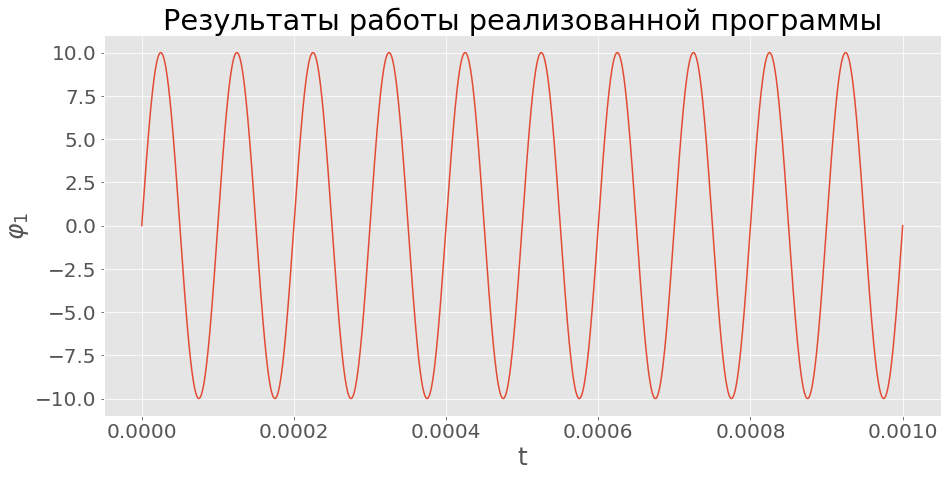

In [27]:
fig = plt.figure(figsize=(15,7))
#plt.subplot(2, 1, 1)
plt.rcParams.update({'font.size': 20})
plt.title('Результаты работы реализованной программы')
plt.xlabel('t', fontsize=25)
plt.ylabel(rf'$\varphi_1$', fontsize=25)
plt.plot(data1.t, data1.phi)
'''
with PdfPages(f'c_phi5.pdf') as pdf:
    pdf.savefig()
    '''
plt.show()

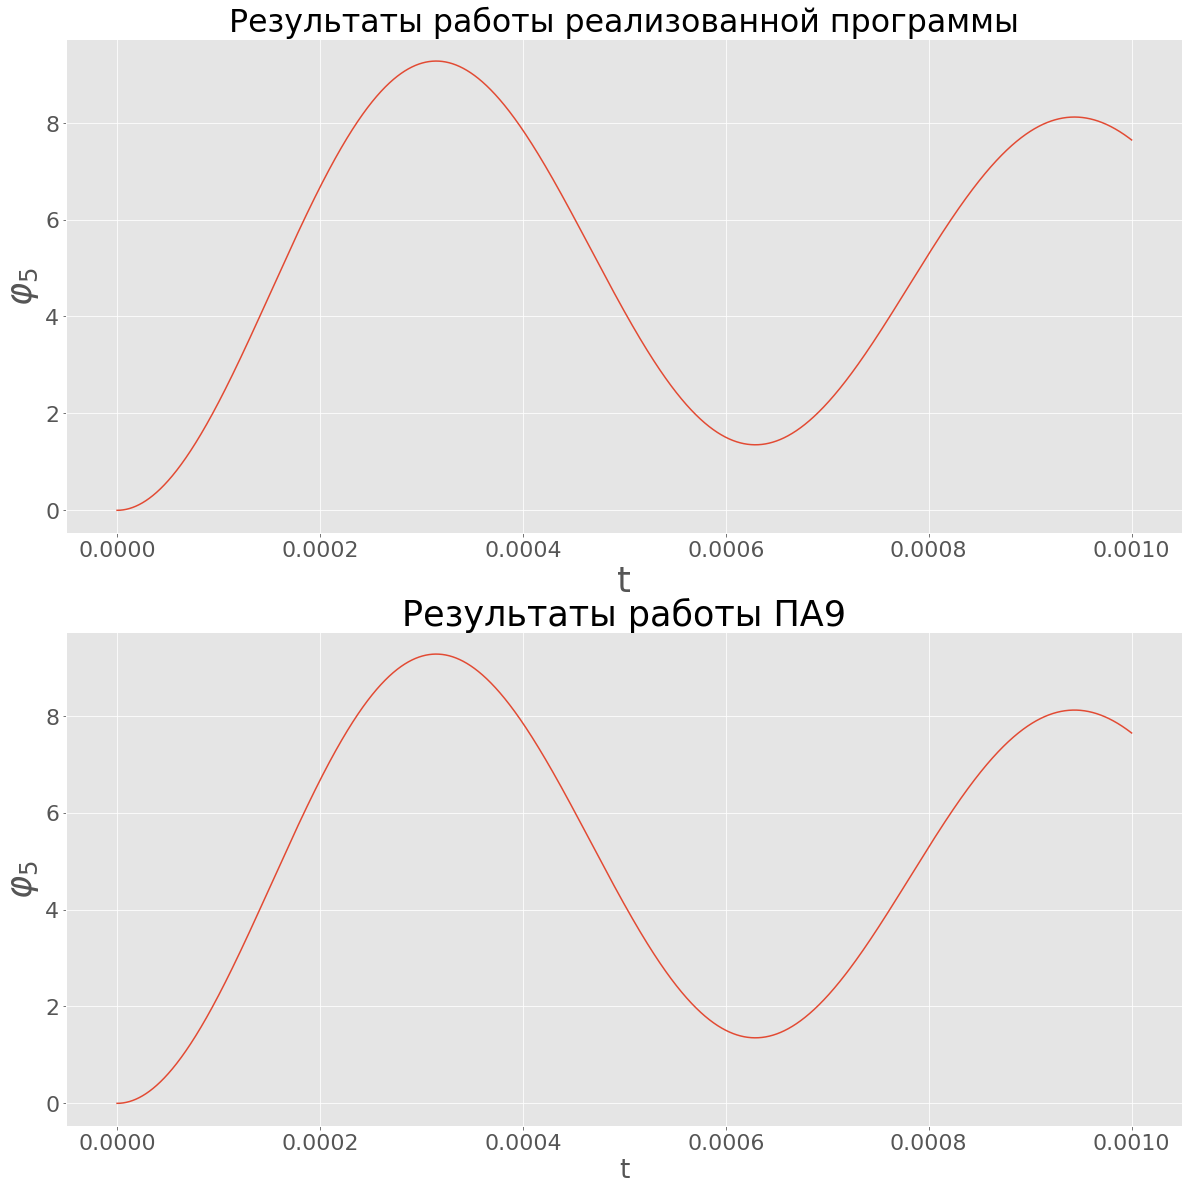

In [49]:
fig = plt.figure(figsize=(20,20))

plt.rcParams.update({'font.size': 22})
plt.subplot(2, 1, 1)
plt.title('Результаты работы реализованной программы')
plt.xlabel('t', fontsize=35)
plt.ylabel(rf'$\varphi_5$', fontsize=35)
plt.plot(data1.t, data5.phi)

plt.rcParams.update({'font.size': 22})
plt.subplot(2, 1, 2)
plt.title('Результаты работы ПА9', fontsize=35)
plt.xlabel('t')
plt.ylabel(rf'$\varphi_5$', fontsize=35)
plt.plot(df_pa9.Time, df_pa9.phi4)

with PdfPages(f'c_pa9_phi5.pdf') as pdf:
    pdf.savefig()
plt.show()